# Stochastic Optimization Introduction

This is a Jupyter Notebook that introduces a few simple Stochastic Optimization algorithms. We start from Random Search, then introduce a Hill Descent algorithm, and finally a bit more involved algorithm that escapes local optima.

# Infrastructure

The cell below introduces a utility function that allows us to plot the parameter space, run the optimizer, record and plot its results in a nice 3D chart. It is not needed to fully understand the internals of the function, it is enough to understand how it is used.

In [287]:
import random
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

colors = ['red', 'white', 'blue', 'yellow', 'cyan', 'orange', 'purple']

def optimize(f, algo, limits=(-5, 5), steps=200, rep=5): # <-- This is the function signature
    
    x = np.outer(np.linspace(*limits, 30), np.ones(30))
    y = x.copy().T # transpose
    z = f(x, y)
    cm = plt.get_cmap("RdYlGn")

    fig = plt.figure(figsize=(10,10), dpi= 100, facecolor='w', edgecolor='k')
    ax = plt.axes(projection='3d', computed_zorder=False)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x, y)')

    ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none', zorder=1)
    
    if algo is not None:
        for i in range(rep):
            sol = (random.uniform(*limits), random.uniform(*limits))
            hist = [(sol, f(*sol))]
            for sol, obj in algo(f, sol, limits, steps):
                hist.append((sol, obj))
            xs, ys, zs = [list(x) for x in zip(*[(tup[0], tup[1], num) for (tup, num) in hist])]
            zs = [v+0.05 for v in zs]
            ax.scatter(xs, ys, zs, marker='o', color=colors[i], zorder=2)
            ax.plot(xs, ys, zs, color=colors[i])
    ax.set_title('Surface plot')
    plt.show()
    

# Our Objective Function

Below we introduce our objective function. As you can see, it has four arguments in total. Arguments `x` and `y` are our decision variables. The function is a 4th degree polynomial function. 

In [288]:
def f(x, y):
    return x**4 + (y+1)**4 - 24*x**2 - 24*(y+1)**2 - 20*x + 10*y

Below we use the `optimize` function that we defined earlier for the first time. By passing `None` to the optimizer algorithm argument, the function will only plot the objective function surface, so that we can visualize it.

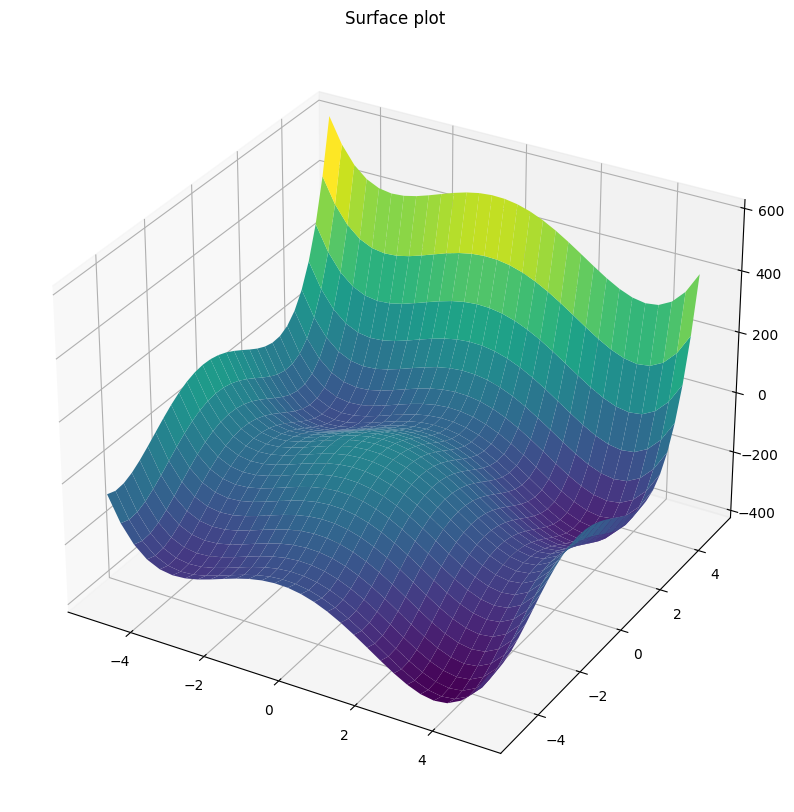

In [289]:
optimize(f, None)

# First Try (Random Walk)

Let us now have a go at implementing an optimization algorithm. The simplest one that we can implement is a Random Walk, which is a variation of Random Search

In [290]:
def opt_random_search(f, sol, limits, rep, q=0.5):
    for i in range(rep):
        sol = (
            min(max(sol[0] + random.uniform(-q, q), limits[0]), limits[1]), # x
            min(max(sol[1] + random.uniform(-q, q), limits[0]), limits[1]) # y
        ) 
        yield sol, f(*sol)

We now use the algorithm we developed above, and pass it along with `f` to the `optimize` function, getting back the plot of the trajectory that the algorithm follows, over several runs.

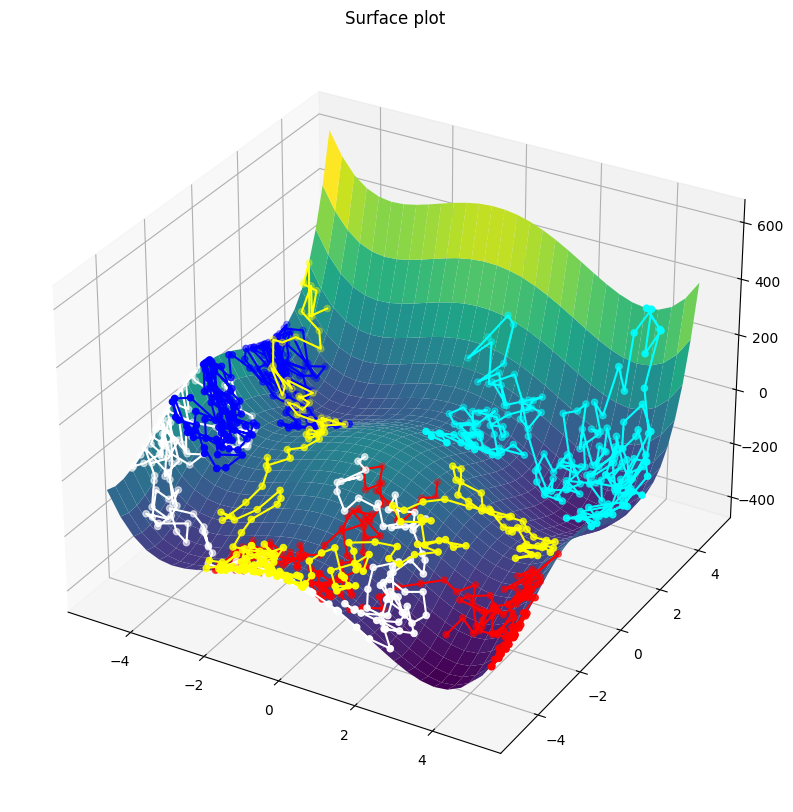

In [291]:
optimize(f, opt_random_search)

# Hill Descent

Let us now try something more involved. In our first attempt, we accepted a solution regardless of whether it was better or worse. Here we will only accept the new solution if it improves our objective function. 

In [292]:
def opt_hill_descent(f, sol, limits, reps, q=1.0):
    fsol = f(*sol)
    for i in range(reps):
        new_sol = (
            min(max(sol[0] + random.uniform(-q, q), limits[0]), limits[1]),
            min(max(sol[1] + random.uniform(-q, q), limits[0]), limits[1])
        )
        fnew_sol = f(*new_sol)
        if fnew_sol < fsol:
            yield new_sol, fnew_sol
            sol = new_sol
            fsol = fnew_sol

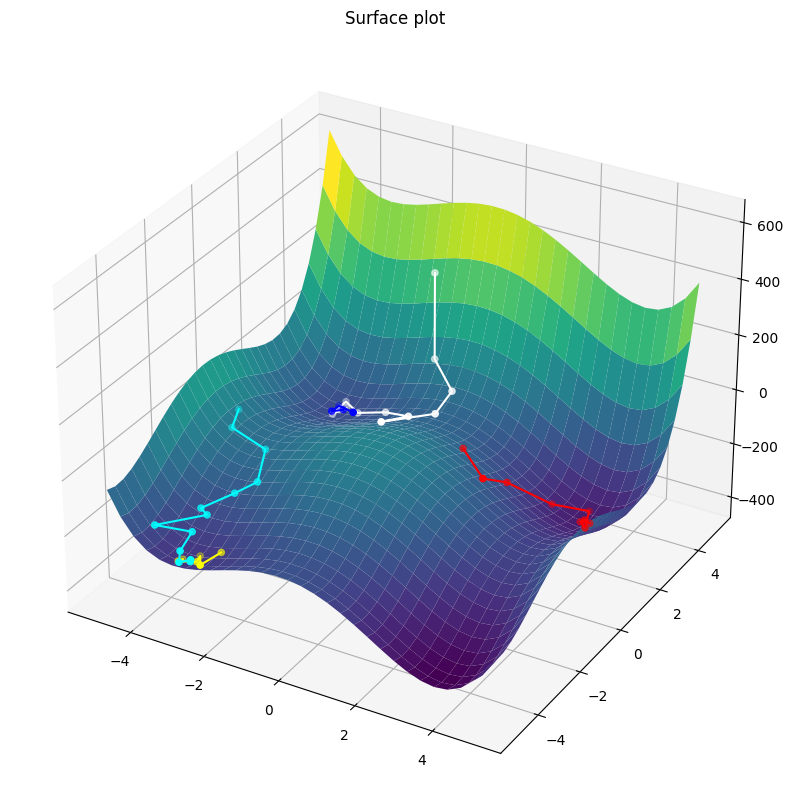

In [293]:
optimize(f, opt_hill_descent)

# Escaping Local Optima

The last algorithm performs well, but it get stuck in local optima. This is because we only accept the new solution if it is better, so once a local optimum is reached, no new solutiosn will be accepted, because all neighboring solutions are worse. 

Instead, if we give a small probability to worse solutions being accepted as well, we can maintain the convergence, while allowing the algorithm to escape to nearby local optima

In [294]:
def opt_stochastic_hill_descent(f, sol, limits, reps, q=1.0, p=0.5):
    fsol = f(*sol)
    for i in range(reps):
        new_sol = (
            min(max(sol[0] + random.uniform(-q, q), limits[0]), limits[1]),
            min(max(sol[1] + random.uniform(-q, q), limits[0]), limits[1])
        )
        fnew_sol = f(*new_sol)
        if fnew_sol < fsol or random.uniform(0, 1) < p:
            yield new_sol, fnew_sol
            sol = new_sol
            fsol = fnew_sol
            p = p*0.98

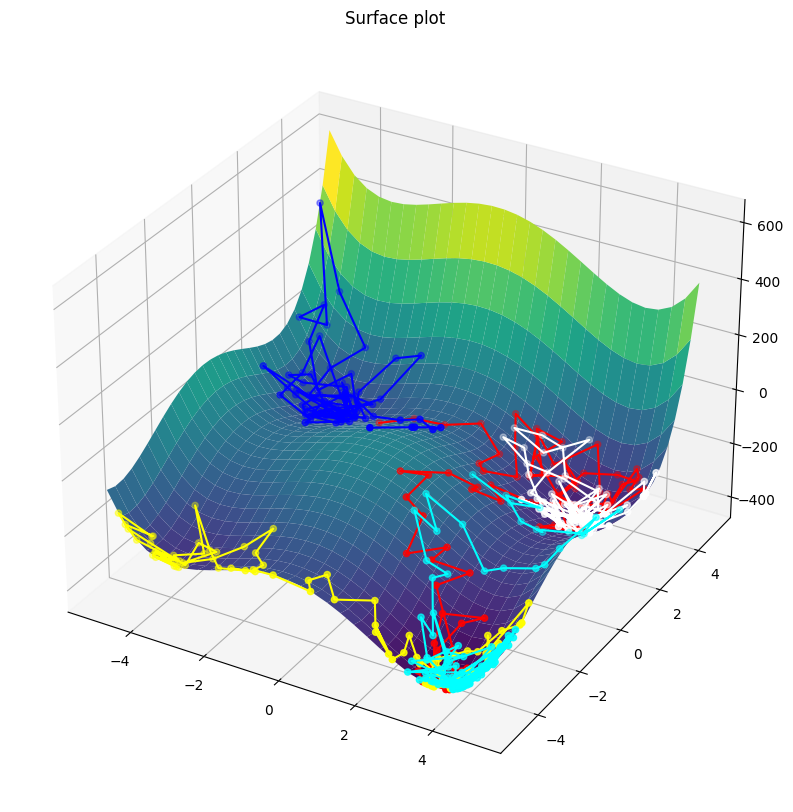

In [300]:
optimize(f, opt_stochastic_hill_descent)